# Análise Estatística - Dados Titanic

## Explorando o problema

In [1]:
#JWLS 20/07
##Bibliotecas python necessárias
#Manipulacao de dados
import pandas as pd

#Testes e recursos estatisticos
import numpy as np
from scipy import stats

#Analise grafica
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
%matplotlib inline

#Modelos, metricas e Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

Primeiramente é nescessário conhecer o banco de dados que será utilizado para obter as respostas das perguntas do teste. Para qualquer banco de dados é preciso destinguir quais variáveis são categoricas ou contínuas. Também é importante verificar se todas as variáveis trazem informações que explicam o fenômeno estudado, pois em geral, esses problemas envolvem grandes quantidade de dados que exigem alto custo computacional. Em alguns casos certas variáveis podem ser combinadas gerando outras variáveis que possuem maiores informações.  

In [2]:
#Importando o banco de dados
dados = pd.read_csv('/home/wesley/MEGAsync/teste_estatistico/titanic_orig.csv')
dados.head() #Analisando as caracteristicas dos dados, 5 primeiras linhas 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Esse banco possui variáveis categóricas e contínuas. As variáveis categóricas aprecem na forma numérica e de texto, em python temos que transformar as variáveis de texto em númericas. Em verificação prévia identificamos a existência de valores faltantes 'NaN' nas variáveis Age, Cabin e Embarked.

### Valores faltantes

O tratamento de valores faltantes é parte crucial para qualquer análise, em geral exitem diversas formas de tratá-los, essas, podem ser simples, como substituir NaN's pela média, mediana, moda ou simplesmente a exclusão dessa instância, ou pode-se optar por abordagens mais complexas, com uso de modelos de regressão os de machine learn simples ou multivariados  para estimativa de valores faltantes. Antes de começar a preencher NaN's é importante verificar se essa variável é importante para o estudo e quais outras variáveis podem ser utilizadas para estimar um valor faltante. Existem diferentes formas de imputação de valores faltantes, algumas são:

Imputação simples

Existindo poucos valores NaN's na variável estudada podemos substituí-lo utilizando alguma medida de tendência central, é uma forma mais simples e rápida.

Imputação simples com regressão

Neste  método  são  considerados  os  valores  das  demais  características  para estimar o valor faltante. Isto pode ser feito baseado em modelos de regressão logístico (binária), multinomial ou linear.

Imputação múltipla

A  Imputação  Múltipla  é  uma  técnica  para  analisar  bancos  de  dados onde  algumas  entradas  são  faltantes.  A  aplicação  dessa técnica  requer  três  passos:  imputação,  análise  e  agrupamento. 

O banco estudado possui valores faltantes nas variáveis Age, Cabin e Embarked. Calculando o total de NaN podemos identificar a melhor forma de preencher esses valores. Assim, calculamos a soma de valores faltantes para cada variável:

In [3]:
print('Soma de valores faltantes em Age:      ', sum(dados['Age'].isnull()))
print('Soma de valores faltantes em Cabin:    ', sum(dados['Cabin'].isnull()))
print('Soma de valores faltantes em Embarked: ', sum(dados['Embarked'].isnull()))

Soma de valores faltantes em Age:       177
Soma de valores faltantes em Cabin:     687
Soma de valores faltantes em Embarked:  2


A variável Cabin é composta de mais de 50%  de valores faltantes. Estimar esses valores pode trazer um viés para futuras análies, dessa forma a melhor opção é excluir essa variável de nosso banco de dados.  

In [4]:
dados2 = dados.drop('Cabin', axis = 1) #Excluindo a coluna Cabin
dados2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


A variável Embarked possui dois valores faltantes, uma abordagem simples que pode ser utilizada e que não cause viés nas inferências posteriores é substituir esses valores pela moda, já que estamos trabalhando com variáveis categóricas. Dessa forma, vamos encontrar a moda e substituir nos valores falatantes:  

In [5]:
moda = dados2['Embarked'].mode()
dados2['Embarked'].fillna(moda[0], inplace = True)
print(sum(dados2['Embarked'].isnull()))

0


A variável idade apresenta 177 valores omissos. Existe diferentes formas para preencher a idade, podemis utilizar a média ou a media de forma mais simples. Porém, podemos gerar um viés negativo ou positivo na nossa análise, pois esses 177 valores aumentaram a frequência da classe média da idade. Uma forma mais coerente é estimar as idades faltantes com modelos de regressão simples ou múltiplos. Para isso, devemos utilizar o maior número de variáveis possíveis e verificar se as mesmas contribuem para a estimativa. Antes de estimar a idade é preciso tentar extrair mais informações dos dados, pricipalmente verificar se é possível criar novas variáveis ou excluir as menos importantes. 

### Novas variáveis

A combinação de uma ou  mais variáveis pode ajudar na estimativa de sobreviventes do Titanic. Uma variável que pode ser facilmente estimada é o tamando da família, pois temos a variável SibSp que indica o número de irmãos ou esposa/esposo e a variável Parch que indica o número de pais e ou filhos. Somando estas variáveis e acrescentando 1 "a própria pessoa", temos o tamanho da família:    

In [6]:
dados2['Family'] = dados2['SibSp'] + dados2['Parch'] + 1
dados2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


Uma observação importante é, deve-se ter cuidado ao se criar novas variáveis, pois elas podem ser autocorrelacionadas e, dessa forma, estariamos inserindo problemas para o nosso modelo. Outro ponto importante é que nem sempre muitas variáveis explicam melhor os dados, e o fundamento da regressão é utilizar sempre modelos mais simples para estimativas.

A variável Name por ser categórica e cada nome representar uma categoria, não traz muita informação para estimar os sobreviventes. Entretanto, ela traz um pronome de tratamento ou grau de título, dessa forma, é importante extrair essa informação e gerar uma nova variável categórica com o título de cada pessoa.

In [7]:
#Quebra a string nome e extrai a informacao do titulo de cada pessoa
dados2['Title'] = dados2.Name.str.extract('([A-Za-z]+)\.', expand=False)
dados2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,Mr


Agora temos os títulos de cada pessoa, entretanto ficamos com 17 títulos diferentes. Alguns desses títulos são semelhantes ou estão na mesma classe de grau. Dessa forma, podemos reduzir o número de títulos agrupando os semelhantes na mesma categoria. 

Os títulos dados a homens nobres ou militares com algum estatuto são Capt, Col, Don, Major, Jonkheer e Sir, já mulheres nobres e de estatuto social elevado recebem títulos de Dona, Lady e Countess. Os títulos de Miss e Mlle são para mulheres solteiras, Ms designa uma mulher sem indicaçao de estado civil, porém nos 2 casos ocorridos, as mesmas viajavam sozinhas, assim foram consideradas solteiras. As mulheres casadas são chamadas de Mrs e Mme. Dessa forma, podemos agrupar alguns desses títulos junto dos que possuem maior frequência.

In [8]:
pd.crosstab(dados2['Title'], dados2['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [9]:
#Agrupando passageiros em titulos mais comuns
dados2['Title'] = dados2['Title'].replace(['Countess'], 'Lady')
dados2['Title'] = dados2['Title'].replace(['Jonkheer', 'Don', 'Capt', 'Major', 'Col', 'Countess', 'Lady',
                                          'Dr', 'Rev', 'Sir'], 'Rich')
dados2['Title'] = dados2['Title'].replace(['Mlle', 'Ms'], 'Miss')
dados2['Title'] = dados2['Title'].replace(['Mme'], 'Mrs')


In [10]:
#Titulos por sexo
pd.crosstab(dados2['Title'], dados2['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rich,3,20


Depois desse agrupamento ficamos com 5 categorias na variável título, assim a dimensionalidade foi bastante reduzida. Agora a variável Name não é mais importante podendo ser excluída do nosso banco de dados. Outra variável que ainda não foi tratada é a Ticket. Analisando um pouco essa variável pode-se notar que ela apresenta valores numéricos e de texto, em geral as letras podem indicar uma classe de valores dos tickets. Porém, não existe uma descrição para essa variável e as informações obtidas pela Classe social e pelo valor pago da passagem trazem bastante informação sobre as condições dos passageiros. Assim, essas variáveis podem ser excluídas do banco de dados.     

In [11]:
#Excluindo Name e Ticket
dados3 = dados2.drop(['Name', 'Ticket'], axis = 1)
dados3.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
0,1,0,3,male,22.0,1,0,7.2500,S,2,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,2,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,1,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,2,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,1,Mr


### Variáveis categóricas e contínuas

O banco de dados está quase pronto para podermos realizar nossa exploração. Sabemos que nosso banco é composto de variáveis quantitativas (contínuas e discretas) e qualitativas "ou categóricas" (nominal e ordinal). As variáveis quantitativas estão prontas para análise, porém as categóricas precisam ser ajustadas para trabalharmos com python. A melhor forma de trabalhar com essas variáveis é atribuir valores para cada atributo, com isso não teremos problemas posteriores. 

In [12]:
#modulo LabelEncoder da biblioteca sklearn
labelencoder = LabelEncoder()

dados4 = dados3
dados4['Sex'] = labelencoder.fit_transform(dados4['Sex'])
dados4['Embarked'] = labelencoder.fit_transform(dados4['Embarked'])
dados4['Title'] = labelencoder.fit_transform(dados4['Title'])
dados4.head()

#Codificacoes
#Sex
#female = 0, male = 1,
#Embarked
#C = 0, Q = 1, S = 2
#Title
#Master = 0, Miss = 1, Mr = 2, Mrs = 3, Rich = 4

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
0,1,0,3,1,22.0,1,0,7.2500,2,2,2
1,2,1,1,0,38.0,1,0,71.2833,0,2,3
2,3,1,3,0,26.0,0,0,7.9250,2,1,1
3,4,1,1,0,35.0,1,0,53.1000,2,2,3
4,5,0,3,1,35.0,0,0,8.0500,2,1,2


### Preenchendo NaN's de Idade

Com o banco de dados pronto é possível estimar os valores para idade. Seguiremos duas abordagens para identificarmos qual a mais apropriada. A primeira abordagem é ajustar um modelo linear múltiplo utilizando as demais variáveis para estimar a idade, a segunda a abordagem é utilizar o modelo de machine learning Randon Forest. 

In [13]:
#Gerando um banco de dados para idade

dados_idade = dados4[['Age', 'Pclass', 'Title', 'Embarked', 'Sex', 'SibSp', 'Parch', 'Fare', 'Family' ]]

#Queremos estimar a idade para isso vamos usar apenas as intâncias com as idades completas
#Divindo o banco em idade_conhecida e idade_desconhecida

idade_conh = dados_idade.loc[(dados_idade.Age.notnull())]
idade_desc = dados_idade.loc[(dados_idade.Age.isnull())]

#Definindo a variável resposta (dependente) e as variáveis preditoras (independentes)

y = idade_conh.values[:, 0]
X = idade_conh.values[:, 1::]

#Preparando as variáveis para estimar os valor de idade perdidas
X_p = idade_desc.values[:, 1::]


Na existência de variáveis categóricas, geralmente substituímos as categorias por números inteiros, porém em modelos de machine learn, isso pode causar um viés, pois o algoritmo pode considerar que existe uma relação de ordem na variável. Uma forma de corrigir esse problema é com o uso de variáveis dummy, esse procedimento conciste em criar um vetor para cada fator e adicionar um valor binário 0 ou 1, para a ocorrência do fator, logo uma variável dummy com 3 fatores será substituída por 3 vetores. Outra forma de diminuir o ruído dos dados é normalizar as variáveis.  

In [14]:
#Atribuindo variaveis dummy a variaveis categoricas
onehotencoder = OneHotEncoder(categorical_features = [0, 1, 2])
X_treino = onehotencoder.fit_transform(X).toarray()
X_est = onehotencoder.fit_transform(X_p).toarray()

#Normalizando os dados
sc = StandardScaler()
X_treino = sc.fit_transform(X_treino)
X_est = sc.transform(X_est)


In [15]:
#Definindo linear multiplo
modelo_linear = LinearRegression()

#Ajustando o modelo
y_pred_linear = modelo_linear.fit(X_treino, y)
print(r2_score(y, modelo_linear.predict(X_treino)))    
mean_squared_error(y, modelo_linear.predict(X_treino)) #Erro quadratico medio

0.424509368962


121.26944588696158

In [16]:
#Definindo o modelo Random Forest

modelo_rf = RandomForestRegressor(n_estimators=1000)
modelo_rf.fit(X_treino, y)
print(r2_score(y, modelo_rf.predict(X_treino)))
mean_squared_error(y, modelo_rf.predict(X_treino))

0.740633178161


54.65470516724104

In [17]:
#Definindo o modelo Support Verctor Regression

modelo_svr = SVR(kernel = 'rbf', C=1e3, gamma=0.1)
modelo_svr.fit(X_treino, y)
print(r2_score(y, modelo_svr.predict(X_treino)))
mean_squared_error(y, modelo_svr.predict(X_treino))

0.56446071797


91.778396632773209

O modelo que apresentou melhores resultados foi o Random Forest. Vamos preencher o valores faltantes com o resultado do melhor modelo. 

In [18]:
idades_pred = modelo_rf.predict(X_est)

#Substituindo no banco de dados
dados4.loc[(dados4.Age.isnull()), 'Age'] = idades_pred

Agora vamos verificar se os valores estimados se distribuem próximo dos valores reais e assim podemos verifar se o modelo está correto. Podemos visualizar isso pelo gráfico de histograma ou densidade.

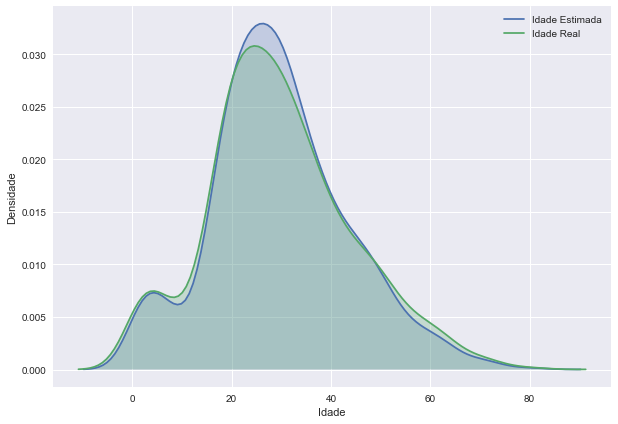

In [19]:
plt.figure(figsize=(10,7))
ax = sns.kdeplot(dados4['Age'], shade = True, label = 'Idade Estimada')
sns.kdeplot(idade_conh['Age'], shade = True, label = 'Idade Real')
ax.set(xlabel='Idade', ylabel='Densidade')
sns.plt.show()

## Estatística Descritiva

Como o banco de dados completo, podemos fazer diversas inferências sobre o incidente com o Titanic. Uma análise descritiva é primordial para no dar conhecimento prévio sobre a distribuição dos dados. Nesta análise utilizaremos medidas e resumo e gráficos, também começaremos a responder as perguntas do teste.

Primeiro vamos verificar o número de passageiros por sexo e classe social.

In [20]:
#Palette de cores para os graficos
tabela_cores = ['#78C850',  # Grass
                 '#F08030',  # Fire
                 '#6890F0',  # Water
                 '#A8B820',  # Bug
                 '#A8A878',  # Normal
                 '#A040A0',  # Poison
                 '#F8D030',  # Electric
                 '#E0C068',  # Ground
                 '#EE99AC',  # Fairy
                 '#C03028',  # Fighting
                 '#F85888',  # Psychic
                 '#B8A038',  # Rock
                 '#705898',  # Ghost
                 '#98D8D8',  # Ice
                 '#7038F8',  # Dragon
                ]

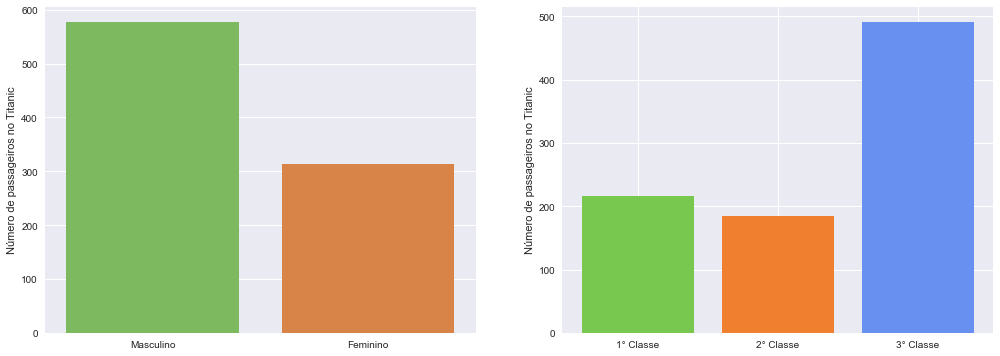

In [21]:
#Graficos de numero de passageiros por sexo e classe
plt.subplots(figsize=([17,6]))
plt.subplot(121)
ax = sns.barplot(dados4['Sex'], dados4.Sex.value_counts(), ci = None, palette = tabela_cores)
ax.set_xticklabels(labels = ['Masculino', 'Feminino'])
ax.set(xlabel='', ylabel='Número de passageiros no Titanic')
plt.subplot(122)
ax = plt.bar([0, 1, 2], dados4.Pclass.value_counts(sort = False), color = tabela_cores)
plt.xticks([0, 1, 2], ('1° Classe', '2° Classe', '3° Classe'))
plt.ylabel('Número de passageiros no Titanic')
sns.despine()

É importante verificar a distribuição da idade dos passageiros. 

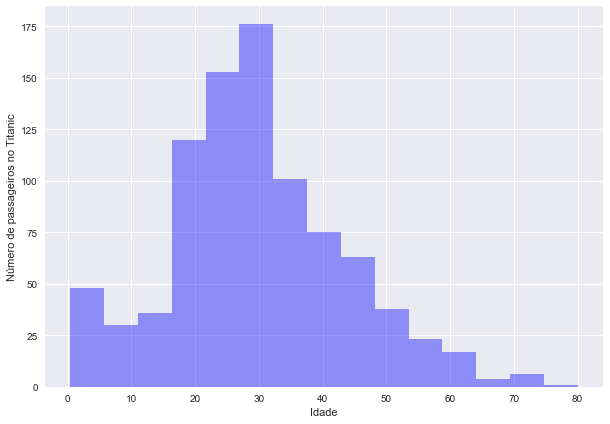

In [22]:
#Graficos da distribuicao de passageiros por idades

plt.figure(figsize=(10,7))
ax = sns.distplot(dados4['Age'], kde = False, color = 'blue', bins = 15)
ax.set(xlabel='Idade', ylabel = 'Número de passageiros no Titanic')
plt.show()

Agora vamos começar a responder as questões do teste.

1) Existe diferença significativa entre as proporções de sobreviventes entre homens e mulheres?

#### Resposta:

Primeiro calculamos as proporções de homens e mulheres sobreviventes. Essa proporção é dada na tabela abaixo.

In [23]:
#Sobreviventes por sexo
dados4[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,0,0.742038
1,1,0.188908


O número de mulheres que sobreviveram é acentuadamente maior em relação aos homens. Podemos avaliar a associação existente entre variáveis qualitativas realizando o teste $\chi^2$ "qui-quadrado". O princípio básico deste teste é comparar proporções, ou seja, as possíveis divergências entre as frequências observadas e esperadas para um evento. 
A hipóteses que queremos testar são:

Hipótese nula: As frequências observadas não são diferentes das frequências esperadas. Não existe diferença entre as frequências (contagens) de sobreviventes por sexo. Assim, não existe associação entre os grupos, sobreviventes por sexo.

Hipótese alternativa: As frequências observadas são diferentes das frequências esperadas. Portanto existe diferença entre as frequências. Assim, existe associação entre os grupos sobreviventes por sexo.

Para calcularmos o teste $\chi^2$ criamos uma tabela com as frequências de sobreviventes por sexo: 

In [24]:
#Tabela de contigencia
dados4['N'] = 1
tabela_sbys = pd.pivot_table(dados4, values = 'N', index = ['Sex'], columns ='Survived', aggfunc = np.sum)
tabela_sbys

Survived,0,1
Sex,,
0,81,233
1,468,109


In [25]:
#Teste X2 qui-quadrado sobreviventes por sexo
obs = [[tabela_sbys[0],tabela_sbys[1]]]
x2, p, dof, exp = stats.chi2_contingency(obs)
x2, p, dof    #X2 calculado, p_valor, graus de liberdade

(260.71702016732104, 1.1973570627755645e-58, 1)

O valor do $\chi^2$ foi de 260,72 com p-valor de 1,19$e^{-58}$, portanto, existe diferenças significativas entre os sobreviventes por sexo, havendo influência do sexo em relação a sobrevivencia.

2) Existe diferença significativa entre as proporções de sobreviventes entre classes diferentes?

#### Resposta:

O raciocínio para resolução dessa questão é o mesmo da quetão anterior, calculamos as proporções sobreviventes por classe social. Em seguida faremos uma tabela de contigência e faremos o teste qui-quadrado.

In [26]:
#Sobreviventes por classe social
dados4[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [27]:
#Tabela de contigencia
tabela_sbyc = pd.pivot_table(dados4, values = 'N', index = ['Pclass'], columns ='Survived', aggfunc = np.sum)
tabela_sbyc

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [28]:
#Teste X2 qui-quadrado sobreviventes por classe
obs_c = [[tabela_sbyc[0],tabela_sbyc[1]]]
x2_c, p_c, dof_c, exp_c = stats.chi2_contingency(obs_c)
x2_c, p_c, dof_c    #X2 calculado, p_valor, graus de liberdade

(102.88898875696056, 4.5492517112987927e-23, 2)

O valor do $\chi^2$ foi de 102,89 com p-valor de 4,24$e^{-23}$, portanto, existe diferenças significativas entre os sobreviventes por classe social, existindo influência da classe social em relação a sobrevivencia.

Para uma interpretação mais interativa foi criado gráficos com relação aos sobreviventes por sexo, classe social e por sexo e classe social.

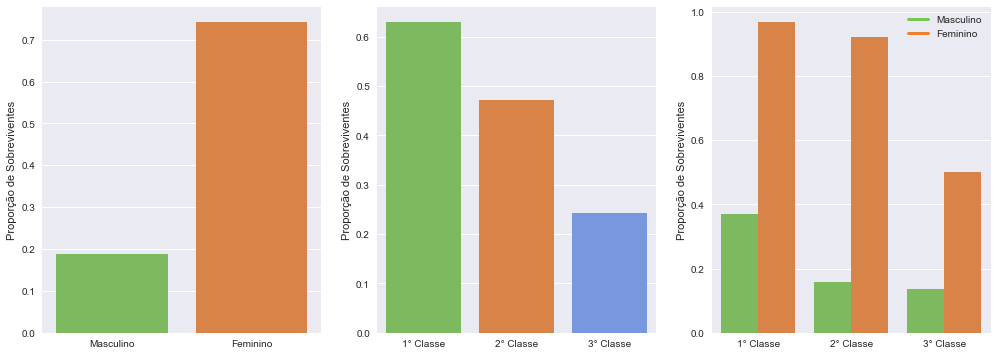

In [29]:
#Graficos de sobreviventes por sexo e classe social

plt.subplots(figsize=([17,6]))
plt.subplot(131)
ax = sns.barplot('Sex', 'Survived', data = dados, ci = None, palette = tabela_cores)
ax.set_xticklabels(labels = ['Masculino', 'Feminino'])
ax.set(xlabel='', ylabel='Proporção de Sobreviventes')
sns.despine()
plt.subplot(132)
ax = sns.barplot('Pclass', 'Survived', data = dados, ci = None, palette = tabela_cores)
ax.set_xticklabels(labels = ['1° Classe', '2° Classe', '3° Classe'])
ax.set(xlabel='', ylabel='Proporção de Sobreviventes')
sns.despine()
plt.subplot(133)
ax = sns.barplot('Pclass', 'Survived', 'Sex', data = dados, ci =None, palette = tabela_cores)
line1 = mlines.Line2D([], [], color='#78C850', label='Masculino', linewidth=3)
line2 = mlines.Line2D([], [], color='#F08030',  label='Feminino', linewidth=3)
plt.legend(ncol=1, loc="best", handles=[line1, line2])
ax.set_xticklabels(labels = ['1° Classe', '2° Classe', '3° Classe'])
ax.set(xlabel ='', ylabel='Proporção de Sobreviventes')
sns.despine()
plt.show()


3) Existe diferença significativa entre as proporções de sobreviventes entre faixas etárias diferentes? Quão mais velho você precisa ser para que você não saísse vivo do desastre?

#### Resposta

A pirâmide etária definida pelo IBGE possui 21 classes, porém com esse número de classes fica difícil visulaizar alguma informção de forma mais simples. Segundo os estatísticos Moretin e Bussab o mínimo de 5 e o máximo 15 classes é o mais indicado para o resumo de qualquer variável. Dessa forma, utilizaremos 11 classes para resumir a faixa etária de passageiros. Posteriomente, criamos a sequência com os intervalos das classes e em seguida vamos criar uma nova coluna na nossa tabela com a indicação da faxa etária de cada passageiro. As classes representam os intervalos numéricos em que a variável quantitativa foi classificada. A amplitude da classe é determinada por $\frac{max(Idade) - min(Idade)}{N. classes}$.


In [30]:
#Definindo a sequencia de classes, a menor idade é 0,4 e a maior é 81 anos,
#assim,o valores minimo e maximo do nosso intervalo sera 0 e 81.
#Amplitude

n = 10
amp = round((dados4['Age'].max() - dados4['Age'].min())/n)
intervalos = list(range(0, 89, int(amp)))

#Agrupando a idade pela faixa etaria
dados4['FaixaEtaria'] = np.nan

for i in range(len(intervalos)-1):
    dados4.loc[(dados4['Age'] >= intervalos[i]) & (dados4['Age'] < intervalos[i+1]), 'FaixaEtaria'] = i  

In [31]:
#Sobreviventes por faixa etária
dados4[['FaixaEtaria','Survived']].groupby(['FaixaEtaria'], as_index = False).mean()

,FaixaEtaria,Survived
0,0.0,0.627119
1,1.0,0.428571
2,2.0,0.366337
3,3.0,0.340081
4,4.0,0.401274
5,5.0,0.311828
6,6.0,0.474576
7,7.0,0.423077
8,8.0,0.000000
9,9.0,0.000000


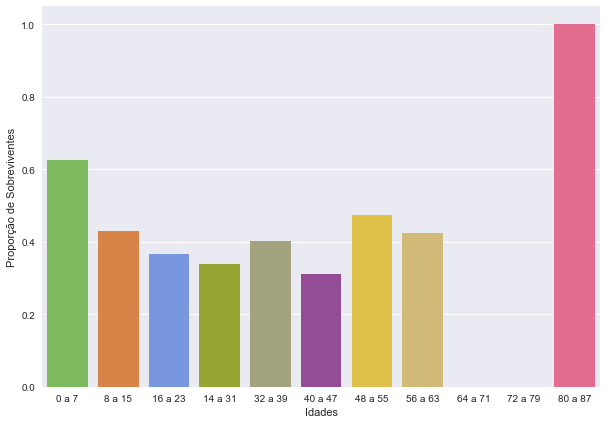

In [32]:
#Graficos da ddensidade de sobreviventes por faixa etaria

plt.figure(figsize=(10,7))
ax = sns.barplot('FaixaEtaria', 'Survived', data = dados4, ci = None, palette = tabela_cores)
ax.set_xticklabels(labels = ['0 a 7', '8 a 15', '16 a 23', '14 a 31', '32 a 39', '40 a 47',
                            '48 a 55', '56 a 63', '64 a 71', '72 a 79', '80 a 87'])
ax.set(xlabel='Idades', ylabel='Proporção de Sobreviventes')
sns.despine()
plt.show()

Vamos verificar se existe diferenças entre as faixas etarias, criamos uma tabela de contigência com as frequências de sobreviventes e não sobreviventes, poteriomente será realizado o teste $\chi^2$.

In [33]:
#Tabela de contigencia
tabela_sbyf = pd.pivot_table(dados4, values = 'N', index = ['FaixaEtaria'], columns ='Survived', aggfunc = np.sum)

tabela_sbyf[0].fillna(0, inplace = True)
tabela_sbyf[1].fillna(0, inplace = True)
tabela_sbyf

Survived,0,1
FaixaEtaria,,
0.0,22.0,37.0
1.0,20.0,15.0
2.0,128.0,74.0
3.0,163.0,84.0
4.0,94.0,63.0
5.0,64.0,29.0
6.0,31.0,28.0
7.0,15.0,11.0
8.0,11.0,0.0


In [34]:
#Teste X2 qui-quadrado sobreviventes por faixa etaria
obs_fe = [[tabela_sbyf[0],tabela_sbyf[1]]]
x2_fe, p_fe, dof_fe, exp_fe = stats.chi2_contingency(obs_fe)
x2_fe, p_fe, dof_fe    #X2 calculado, p_valor, graus de liberdade

(30.866781352903551, 0.00061719434549436646, 10)

Dessa forma, verificamos que existe diferença significativa entre o grupo de sobreviventes pelas diferentes faixas etárias, ou seja, a faixa etária influencia nas chances de sobrevivência. Em relação há quanto mais velho você precisa ser para ter menos chances de escapar, temos, pelo gráfico da proporção de sobreviventes por faixa etária é possível visualizar que a partir dos 64 anos de vida a probabilidade de sobrevivência foi quase nula, há não ser pelo fato que na classe 80 a 88 anos, 100% sobreviveram, porém pela tabela de contigência constamos que existe apenas uma ocorrência para essa faixa etária, ou seja, apenas uma pessoa acima de 64 anos de idade sobreviveu. Logo, qualquer pessoa com menos de 64 anos de idade possuía melhores chances de sobreviver.  

4) Quais variáveis explicam melhor os dados? Explique quais testes e modelos foram utilizados em sua resposta.

#### Resposta:

 Em um primeiro instante, pode-se pensar que quanto maior o banco de dados, representados por um volume elevado de variáveis descritivas de observações,  seja  preferível  para  a  explicação de um fenômeno.  Contudo,  algumas variáveis não acrescentam nehuma informação adicional para explicação do fenômeno, além de um grande número de variáveis aumentar a dimensionalidade dos dados gerando alto custo computacional e as vezes inserindo um viés ao modelo. Diante disso, é importante verificar quais as variáveis que mais contribuem para o estudo. A correlação entre as variáveis dependentes pode trazer essa informação, lembrando que, variáveis que apresentarem baixa correlação podem ser excluídas do modelo e variáveis com alta correlação entre si podem ser substituidas uma pela outra. Cabe ressaltar que quase todos os métodos da estatística classe para inferir contribuição de variáveis são lineares, logo ao se trabalhar com problemas não lineares esses métodos apresentam baixa eficiência. Uma alternativa é fazer uso de modelos de machine learn como, árvores de decisões, florestas aleátorias e redes neurais.

In [35]:
#Dados

dados5 = dados4[['Survived', 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
                 'Family', 'Title', 'FaixaEtaria']]

#Definindo a variável resposta (dependente) e as variáveis preditoras (independentes)

y_target = dados5.values[:, 0]
X_feature = dados5.values[:, 1::]


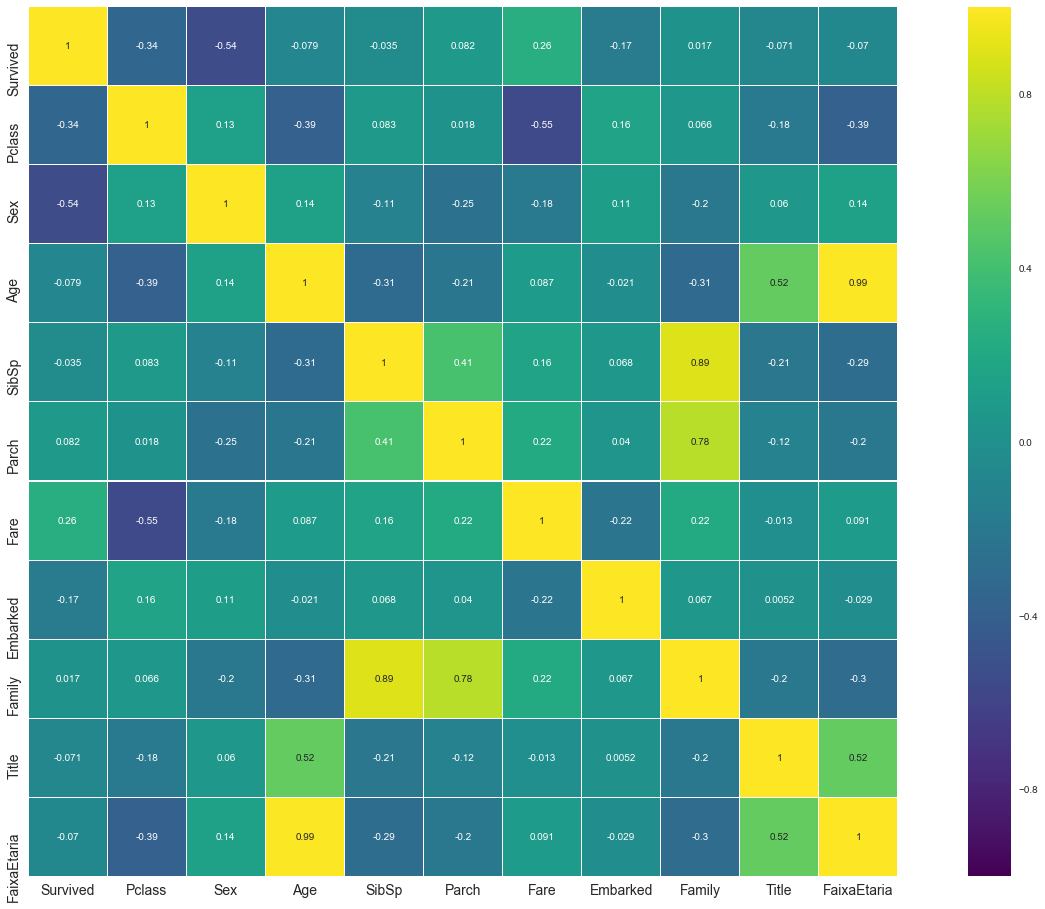

In [36]:
#Matriz de correlacao

matriz_corr = dados5.corr()
ax = plt.subplots(figsize=(25,16))
sns.plt.yticks(fontsize=14)
sns.plt.xticks(fontsize=14)
sns.heatmap(matriz_corr, cmap='viridis', linewidths=0.1,vmax=1.0, square=True, annot=True)
plt.show()



In [37]:
#Definindo o modelo Random Forest

modelo_rf1 = RandomForestRegressor(n_estimators=1000)
modelo_rf1.fit(X_feature, y_target)
print(r2_score(y_target, modelo_rf1.predict(X_feature)))
mean_squared_error(y_target, modelo_rf1.predict(X_feature))
importances = modelo_rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelo_rf1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

0.891900310606


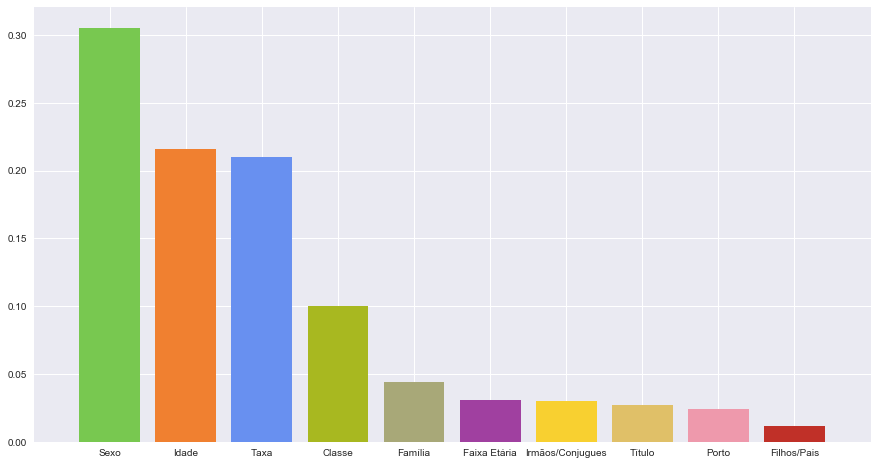

In [38]:
# Grafico para importancia das variaveis
plt.figure(figsize = ([15,8]))
plt.bar(range(X_feature.shape[1]), importances[indices],
       color=tabela_cores, align="center")
plt.xticks(range(X_feature.shape[1]), ['Sexo', 'Idade', 'Taxa', 'Classe', 'Família', 'Faixa Etária', 
                                       'Irmãos/Conjugues', 'Título',  'Porto', 'Filhos/Pais'])
plt.xlim([-1, X_feature.shape[1]])
plt.show()

#['Sexo', 'Idade', 'Taxa', 'Classe', 'Família', 'Faixa Etária', 'Irmãos/Conjugues', 'Título',  'Porto', 'Filhos/Pais']
#['Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family', 'Title', 'FaixaEtaria']

3) Crie um modelo que defina a probabilidade de sobrevivência a partir das características de cada passageiro. Obs.: Siga uma metodologia que valide o modelo criado.

#### Resposta:

O modelo clássico para este tipo de análise é o modelo de regressão logística. Com ele podemos estimar a probalidade de alguém sobreviver de acordo com as informações obtidas com as demais variáveis. 

In [39]:
#Regressao logistica

modelo_lr = LogisticRegression(C=1., solver='lbfgs')
modelo_lr.fit(X_feature, y_target)
print(modelo_lr.score(X_feature, y_target))          #Acuracia do modelo
mean_squared_error(y_target, modelo_lr.predict(X_feature))



0.808080808081


0.19191919191919191

In [40]:
modelo_rf2 = RandomForestRegressor(n_estimators=1000)
modelo_rf2.fit(X_feature, y_target)
print(r2_score(y_target, modelo_rf2.predict(X_feature)))
mean_squared_error(y_target, modelo_rf2.predict(X_feature))


0.891110087464


0.025753169804935576

Ambos os modelos apresentam bons resultados, porém o modelo com menor erro quadrado médio é o mais indicado para realizar estimativas. Um ponto positivo do modelo logístico é que é possível facilmente estimar a probabilidade de sobrevivência de um passageiro.

4) Bônus: Qual probabilidade de um homem solteiro de 19 anos que embarcou em Southampton sozinho na terceira classe sobreviva ao desastre?

#### Resposta:


In [41]:
#Calculando a probalidade
#Lembrando a ordem das informacoes de X
#Codificacoes
#Sex
#female = 0, male = 1,
#Embarked
#C = 0, Q = 1, S = 2
#Title
#Master = 0, Miss = 1, Mr = 2, Mrs = 3, Rich = 4
#['Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family', 'Title', 'FaixaEtaria']

X_novo = np.array([3., 1., 19., 0., 0., 5., 2., 1., 2., 2.])
modelo_lr.predict_proba(X_novo)



/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.86607192,  0.13392808]])

Logo, um passageiro com essas características tem probalidade de sobrevivência de 13,65%.